In [18]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
plt.rcParams['figure.figsize'] = [20, 8]

In [19]:
from google.colab import files
df = files.upload()
df = pd.read_csv('Palladium.csv')
df = df.reset_index()['Close']
df.head()

Saving Palladium.csv to Palladium.csv


0    1067.5
1    1096.0
2    1088.0
3    1102.5
4    1091.5
Name: Close, dtype: float64

In [ ]:
# 2. Đọc file csv và gắn index
# df = pd.read_csv('../Dataset/Gold.csv')
# df = df.reset_index()['Close']
# df

0       2179.120
1       2172.300
2       2165.990
3       2165.400
4       2165.400
          ...   
1689    1287.775
1690    1286.710
1691    1292.765
1692    1292.765
1693    1292.765
Name: Close, Length: 1694, dtype: float64

In [20]:
# 3. Scaler data
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df).reshape(-1,1))

In [21]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [22]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [23]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [24]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [25]:
# 8. Define LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100,1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [26]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 100, batch_size=64, verbose=1)

Epoch 1/100
19/19 [==============================] - 13s 335ms/step - loss: 0.0432 - val_loss: 0.0067
Epoch 2/100
19/19 [==============================] - 4s 191ms/step - loss: 0.0058 - val_loss: 0.0035
Epoch 3/100
19/19 [==============================] - 4s 191ms/step - loss: 0.0034 - val_loss: 0.0018
Epoch 4/100
19/19 [==============================] - 5s 270ms/step - loss: 0.0031 - val_loss: 0.0013
Epoch 5/100
19/19 [==============================] - 4s 195ms/step - loss: 0.0030 - val_loss: 0.0018
Epoch 6/100
19/19 [==============================] - 4s 192ms/step - loss: 0.0029 - val_loss: 0.0013
Epoch 7/100
19/19 [==============================] - 4s 218ms/step - loss: 0.0032 - val_loss: 0.0018
Epoch 8/100
19/19 [==============================] - 5s 245ms/step - loss: 0.0028 - val_loss: 0.0015
Epoch 9/100
19/19 [==============================] - 4s 191ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 10/100
19/19 [==============================] - 4s 192ms/step - loss: 0.0026 - val_l

In [27]:
# 10. Dự báo dữ liệu test
y_pred = model.predict(X_test)

24/24 [==============================] - 3s 59ms/step


In [28]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
y_pred = scaler.inverse_transform(y_pred)

In [29]:
train_size1 = int(0.6 * len(df))
test_size1 = len(df) - train_size

train_data1 = df[:train_size]
test_data1 = df[train_size:]

x_test1 = np.array(test_data1.index).reshape(-1, 1)
y_test1 = np.array(test_data1)

In [30]:
# 12. Đánh giá độ chính xác thuật toán
# Tính MSE - Mean Squared Error - Sai số bình phương trung bình
test_mse = mean_squared_error(y_test1[time_step + 1:], y_pred)
print('Testing MSE:', test_mse)

# Tính RMSE - Root Mean Squared Error - Sai số bình phương trung bình
test_rmse = math.sqrt(test_mse)
print('Testing RMSE:', test_rmse)

# Tính MAPE - Mean Absolute Percentage Error - Tỷ lệ phần trăm sai số tuyệt đối trung bình
test_mape = mean_absolute_percentage_error(y_test1[time_step + 1:], y_pred)
print('Testing MAPE:', test_mape)

Testing MSE: 3178.89238104522
Testing RMSE: 56.38166706514823
Testing MAPE: 0.02726982984648196


In [31]:
# 13. Tạo hàm dự báo
def predict(n_steps, temp_input_1, x_input_1, model, day_predict):
    lst_output = []
    temp_input = temp_input_1.copy()
    x_input = x_input_1.copy()
    i = 0

    while(i < day_predict):
        if(len(temp_input) > n_steps):
            x_input=np.array(temp_input[1:])
            x_input=x_input.reshape(1,-1)
            x_input = x_input.reshape((1, n_steps, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input=temp_input[1:]
            lst_output.extend(yhat.tolist())
            i=i+1
        else:
            x_input = x_input.reshape((1, n_steps,1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i=i+1
    return lst_output

In [16]:
# Dự đoán 30, 60, 90 ngày tiếp theo
n_steps = 100
x_input = test_data[len(test_data) - n_steps:].reshape(1,-1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output_30 = predict(n_steps, temp_input, x_input, model, 30)
lst_output_60 = predict(n_steps, temp_input, x_input, model, 60)
lst_output_90 = predict(n_steps, temp_input, x_input, model, 90)

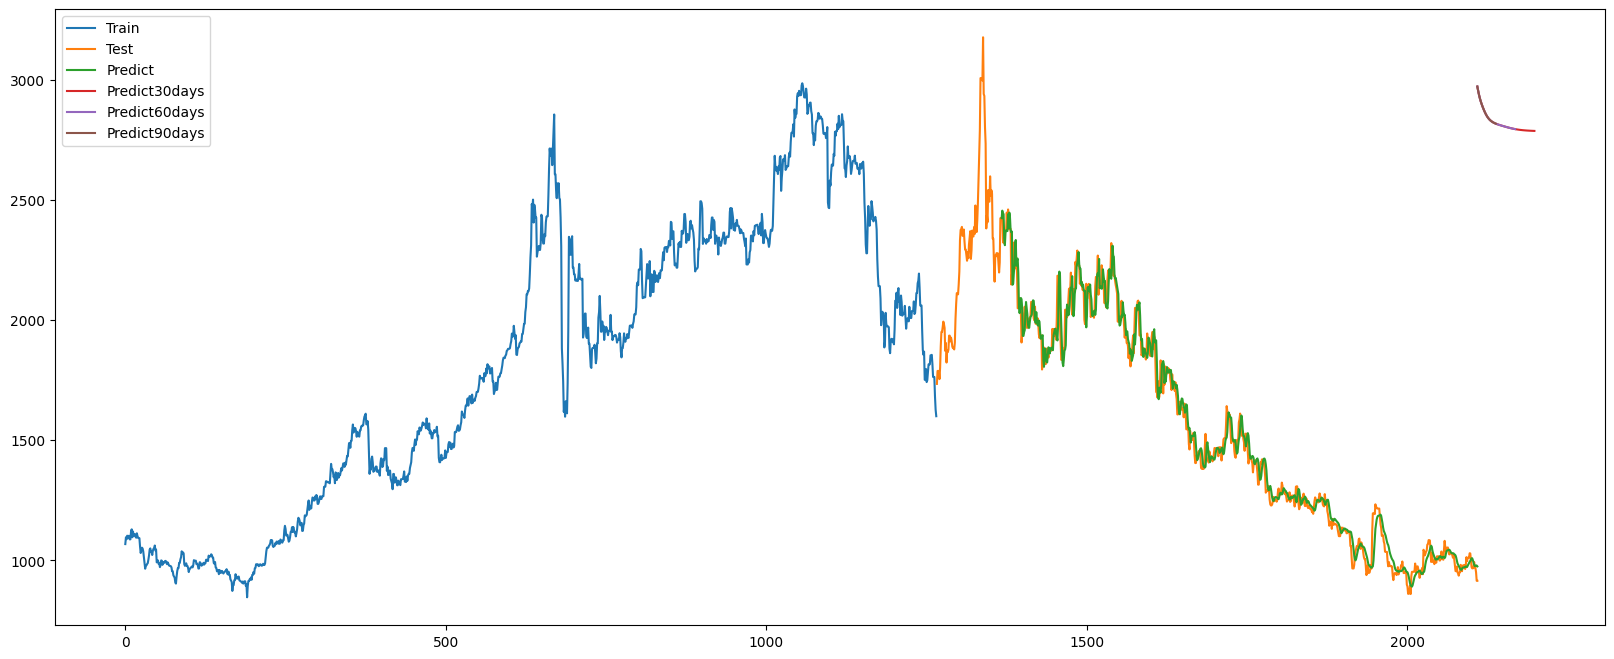

<Figure size 1600x900 with 0 Axes>

In [32]:
# 14.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output_90))

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output_60))

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output_30))

plt.legend(['Train','Test','Predict','Predict30days','Predict60days','Predict90days'])
plt.figure(figsize=(16,9))
plt.show()